# (시도 2) Node Classification with Graph Neural Networks
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [GNN]

- 쓸 수 있는 real data
- 어떤 data에서 적용이 되지 않을까?
- 모든 노드가 연결되었을때 오히려 정확도가 낮아지는 등
- 결측값이 존재한다면 그 값을 어떤 확률로 0/1을 채워넣어야 할까?
- X 수가 일정하지 않는다면?

review data?
- x는 단어, y의 class는 별점!

설문조사
- 할목별 문항을 이진화, class는 설문조사 결과

### Import

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-06-28 21:53:01.492260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 21:53:01.492287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## p=0.1

### 데이터 구성

In [2]:
p=0.1

In [3]:
papers =pd.concat([pd.concat([pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X4','X5','X6']),
                             pd.DataFrame(np.array([['Deep learning']*500]).reshape(500,1),columns=['subject'])],axis=1),
            pd.concat([ pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X1','X2','X3']),
              pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X4','X5','X6']),
                      pd.DataFrame(np.array([['Reinforcement learning']*500]).reshape(500,1),columns=['subject'])],axis=1)],axis=0,ignore_index=True).reset_index().rename(columns={'index':'paper_id'})
papers['paper_id'] = papers['paper_id']+1
papers

,paper_id,X1,X2,X3,X4,X5,X6,subject
0,1,1,1,1,0,0,0,Deep learning
1,2,1,1,1,0,0,0,Deep learning
2,3,0,1,1,0,1,0,Deep learning
3,4,1,1,1,0,0,0,Deep learning
4,5,1,1,1,0,0,0,Deep learning
...,...,...,...,...,...,...,...,...
995,996,0,0,0,1,0,1,Reinforcement learning
996,997,0,0,0,1,1,1,Reinforcement learning
997,998,0,0,0,1,1,1,Reinforcement learning
998,999,0,0,0,1,0,1,Reinforcement learning


0.5 vs 0.5

In [4]:
# 나머지 1250 행 reinforcement learning 행 500~1000를 target, source에 임의 부여
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1000,1)),np.random.choice(range(1,501),size=(1000,1))]).reshape(1000,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1000,1)),np.random.choice(range(501,1001),size=(1000,1))]).reshape(1000,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2000,1)),np.random.choice(range(501,1001),size=(2000,1))]).reshape(2000,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

### 그래프 표현

In [5]:
#collapse
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

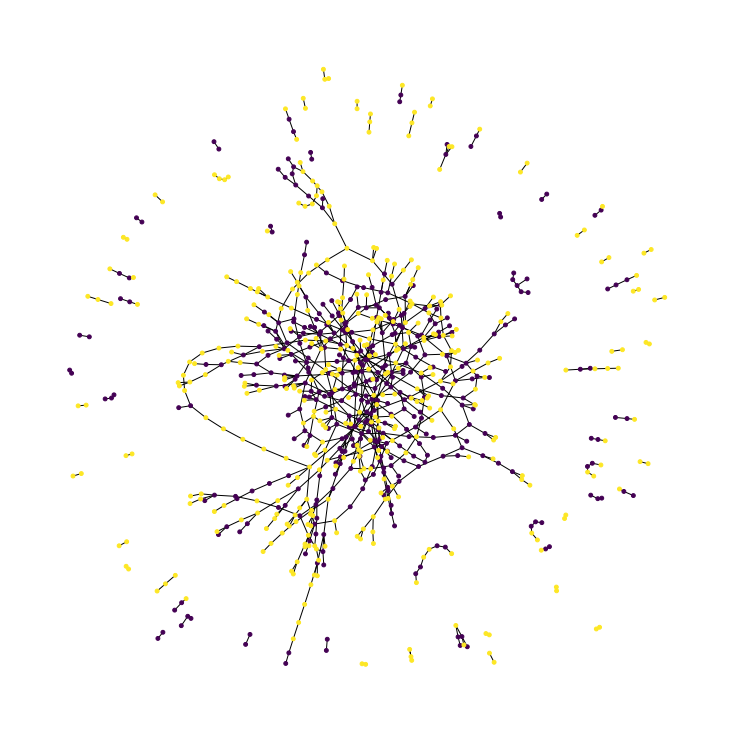

In [6]:
#collapse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [7]:
#collapse
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (476, 8)
Test data shape: (524, 8)


In [8]:
#collapse
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [9]:
#collapse
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],verbose=0,
    )

    return history

In [10]:
#collapse
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [11]:
#collapse
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [12]:
#collapse
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [13]:
#collapse
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 6)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1432        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [14]:
#collapse_output
history = run_experiment(baseline_model, x_train, y_train)

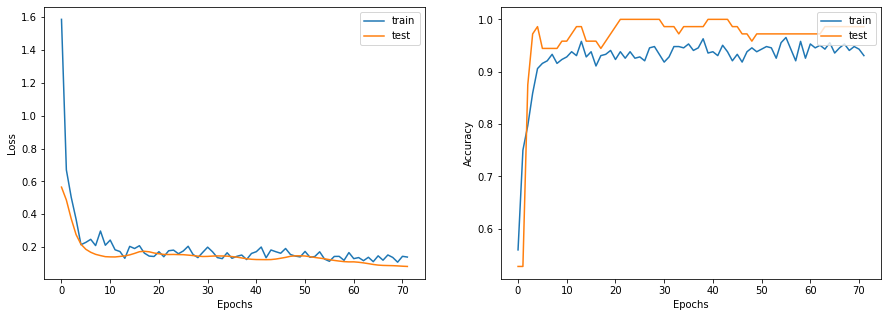

In [15]:
display_learning_curves(history)

In [16]:
#collapse
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 98.66%


#### p = 0.1 Test accuracy: 1) 98.37% 2) 99.19% 3) 98.66%

### baseline 모델 예측

In [17]:
#collapse
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [18]:
#collapse
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 74.56%
- Reinforcement learning: 25.44%
Instance 2:
- Deep learning: 60.12%
- Reinforcement learning: 39.88%


In [19]:
#collapse
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 4000)
Edge weight shape: (4000,)
Nodes shape: (1000, 6)


In [20]:
#collapse
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [21]:
#collapse
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


### Train the GNN model

In [22]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.03785368 -0.02364569]
 [ 0.037884   -0.02356724]
 [ 0.10132159 -0.19648255]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1000, 32)                1432      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (1000, 32)                2368      
                                                                 
 logits (Dense)              multiple           

In [23]:
#collapse_Output
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

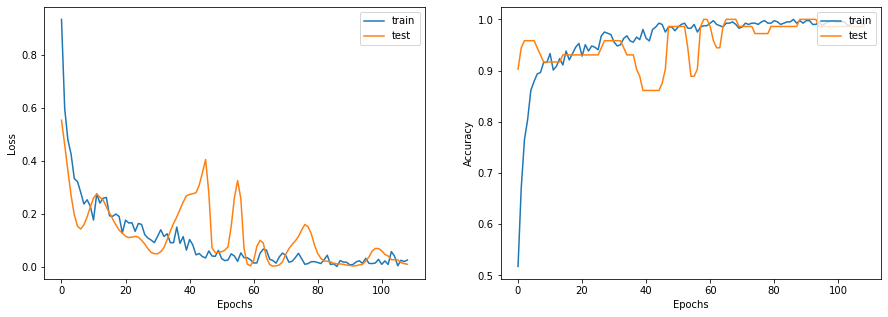

In [24]:
display_learning_curves(history)

In [25]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 99.81%


#### p = 0.1, 0.5 vs 0.5 Test accuracy: 1) 96.75% 2) 99.8% 3) 99.81%

In [26]:
#collapse
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [27]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 99.91%
- Reinforcement learning: 0.09%
Instance 2:
- Deep learning: 0.96%
- Reinforcement learning: 99.04%


### p = 0.1, 0.1 vs 0.9

In [28]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1800,1)),np.random.choice(range(1,501),size=(1800,1))]).reshape(1800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1800,1)),np.random.choice(range(501,1001),size=(1800,1))]).reshape(1800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(400,1)),np.random.choice(range(501,1001),size=(400,1))]).reshape(400,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [29]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [30]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [31]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [32]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

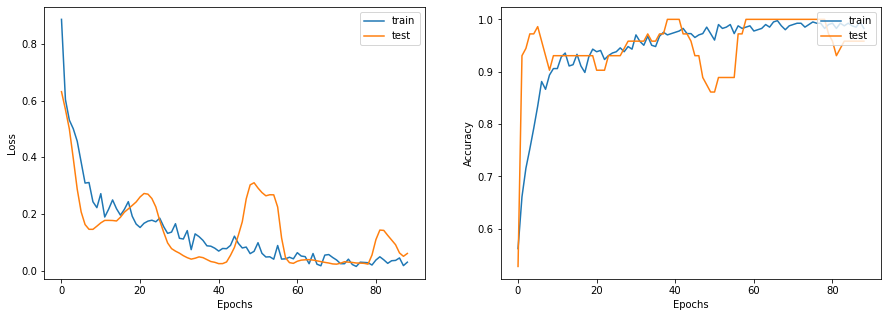

In [33]:
display_learning_curves(history)

In [34]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 99.81%


#### p = 0.1, 0.1 vs 0.9 Test accuracy: 1) 98.37% 2) 98.39% 3) 99.81%

In [35]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [36]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 99.35%
- Reinforcement learning: 0.65%
Instance 2:
- Deep learning: 11.78%
- Reinforcement learning: 88.22%


### p = 0.1, 0.2 vs 0.8

In [37]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(1,501),size=(1600,1))]).reshape(1600,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(800,1)),np.random.choice(range(501,1001),size=(800,1))]).reshape(800,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [38]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [39]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [40]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [41]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

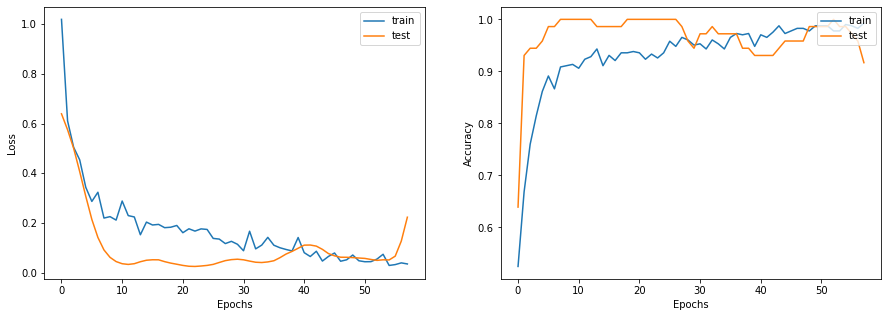

In [42]:
display_learning_curves(history)

In [43]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.52%


#### p = 0.1, 0.2 vs 0.8 Test accuracy: 1) 98.17% 2) 97.98% 3) 97.52%

In [44]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [45]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 81.8%
- Reinforcement learning: 18.2%
Instance 2:
- Deep learning: 21.66%
- Reinforcement learning: 78.34%


### p = 0.1, 0.3 vs 0.7

In [46]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2800,1)),np.random.choice(range(1,501),size=(2800,1))]).reshape(2800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(2800,1)),np.random.choice(range(501,1001),size=(2800,1))]).reshape(2800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [47]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [48]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [49]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [50]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

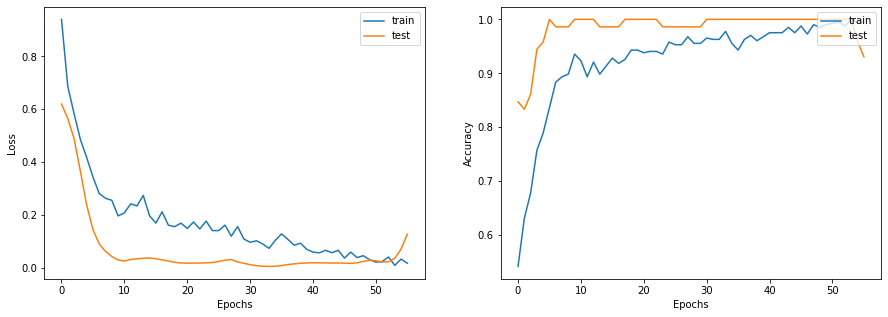

In [51]:
display_learning_curves(history)

In [52]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 98.85%


#### p = 0.1, 0.3 vs 0.7 Test accuracy: 1) 96.95% 2) 99.4% 3) 98.85%

In [53]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [54]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 6800)
New node_features shape: (1002, 6)
New edges shape: (2, 6814)
Instance 1:
- Deep learning: 82.53%
- Reinforcement learning: 17.47%
Instance 2:
- Deep learning: 60.91%
- Reinforcement learning: 39.09%


### p = 0.1, 0.4 vs 0.6

In [55]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(1,501),size=(1200,1))]).reshape(1200,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [56]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [57]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [58]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [59]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

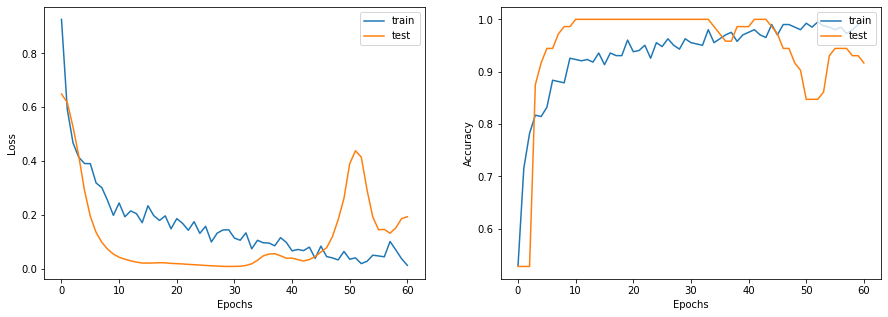

In [60]:
display_learning_curves(history)

In [61]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 98.47%


#### p = 0.1, 0.4 vs 0.6 Test accuracy: 1) 97.76% 2) 99.4% 3) 98.47%

In [62]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [63]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 97.4%
- Reinforcement learning: 2.6%
Instance 2:
- Deep learning: 37.25%
- Reinforcement learning: 62.75%


## p=0.2

### 데이터 구성

In [64]:
p=0.2

In [65]:
papers =pd.concat([pd.concat([pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X4','X5','X6']),
                             pd.DataFrame(np.array([['Deep learning']*500]).reshape(500,1),columns=['subject'])],axis=1),
            pd.concat([ pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X1','X2','X3']),
              pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X4','X5','X6']),
                      pd.DataFrame(np.array([['Reinforcement learning']*500]).reshape(500,1),columns=['subject'])],axis=1)],axis=0,ignore_index=True).reset_index().rename(columns={'index':'paper_id'})
papers['paper_id'] = papers['paper_id']+1

In [66]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1000,1)),np.random.choice(range(1,501),size=(1000,1))]).reshape(1000,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1000,1)),np.random.choice(range(501,1001),size=(1000,1))]).reshape(1000,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2000,1)),np.random.choice(range(501,1001),size=(2000,1))]).reshape(2000,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

### 그래프 표현

In [67]:
#collapse
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

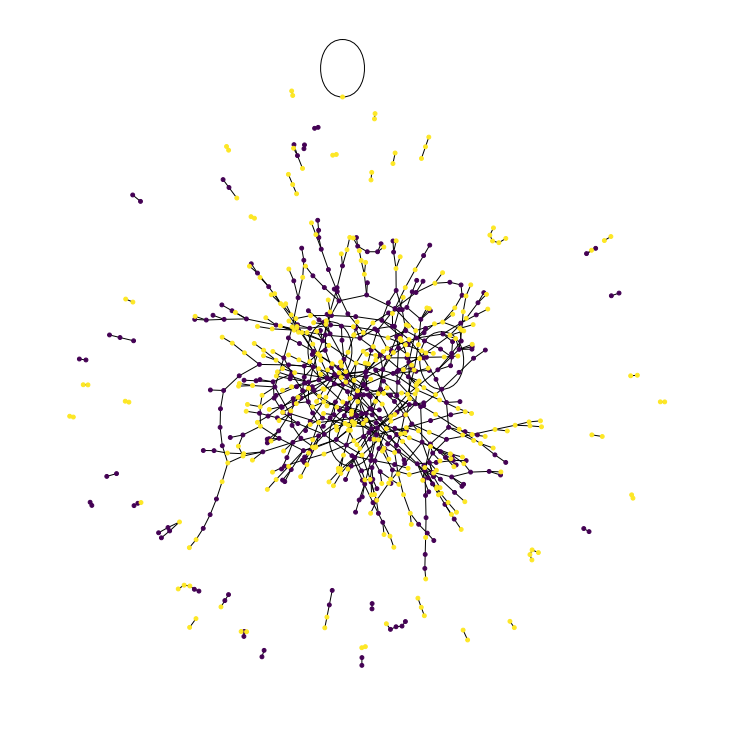

In [68]:
#collapse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [69]:
#collapse
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (512, 8)
Test data shape: (488, 8)


In [70]:
#collapse
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [71]:
#collapse
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [72]:
#collapse_output
history = run_experiment(baseline_model, x_train, y_train)

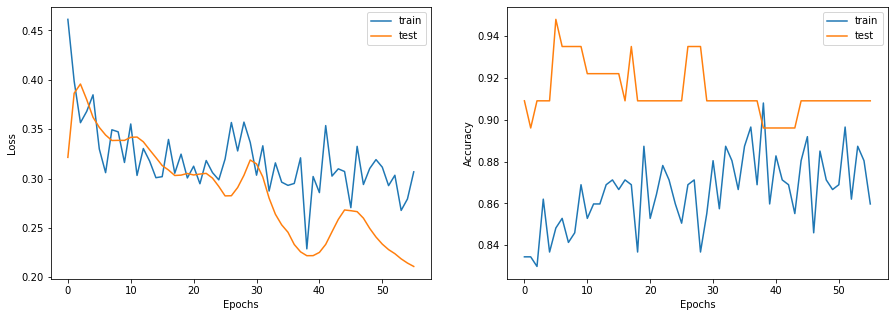

In [73]:
display_learning_curves(history)

In [74]:
#collapse
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 94.88%


#### p=0.2 Test accuracy: 1) 94.8% 2) 94.16% 3) 94.88%

### baseline 모델 예측

In [75]:
#collapse
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 20.68%
- Reinforcement learning: 79.32%
Instance 2:
- Deep learning: 46.68%
- Reinforcement learning: 53.32%


In [76]:
#collapse
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 4000)
Edge weight shape: (4000,)
Nodes shape: (1000, 6)


In [77]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.0650681  -0.12954327]
 [-0.09058921 -0.05385122]
 [-0.07080038  0.01732346]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1000, 32)                1432      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (1000, 32)                2368      
                                                                 
 logits (Dense)              multiple           

### Train the GNN model

In [78]:
#collapse_Output
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

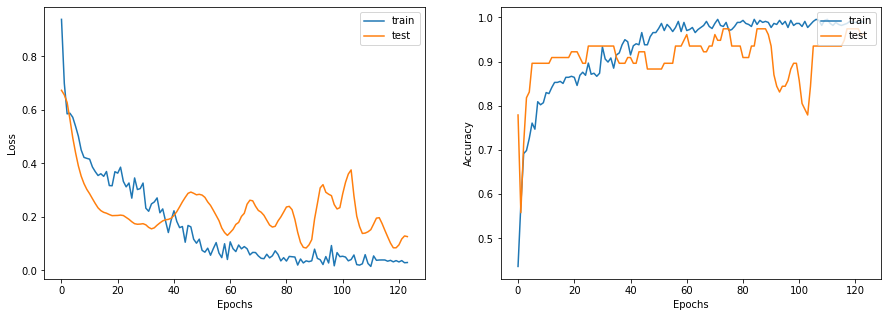

In [79]:
display_learning_curves(history)

In [80]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.54%


#### p=0.2, 0.5 vs 0.5 Test accuracy: 1) 97.0% 2) 96.89% 3) 97.54%

In [81]:
#collapse
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [82]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 94.15%
- Reinforcement learning: 5.85%
Instance 2:
- Deep learning: 0.71%
- Reinforcement learning: 99.29%


### p = 0.2, 0.1 vs 0.9

In [83]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1800,1)),np.random.choice(range(1,501),size=(1800,1))]).reshape(1800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1800,1)),np.random.choice(range(501,1001),size=(1800,1))]).reshape(1800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(400,1)),np.random.choice(range(501,1001),size=(400,1))]).reshape(400,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [84]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [85]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [86]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [87]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

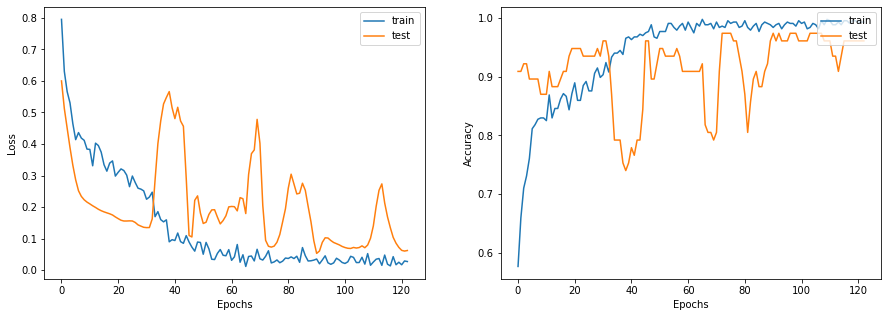

In [88]:
display_learning_curves(history)

In [89]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 98.16%


#### p = 0.2, 0.1 vs 0.9 Test accuracy: 1) 98.6% 2) 94.16% 3) 98.16%

In [90]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [91]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 94.64%
- Reinforcement learning: 5.36%
Instance 2:
- Deep learning: 0.09%
- Reinforcement learning: 99.91%


### p = 0.2, 0.2 vs 0.8

In [92]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(1,501),size=(1600,1))]).reshape(1600,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(800,1)),np.random.choice(range(501,1001),size=(800,1))]).reshape(800,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [93]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [94]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [95]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [96]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

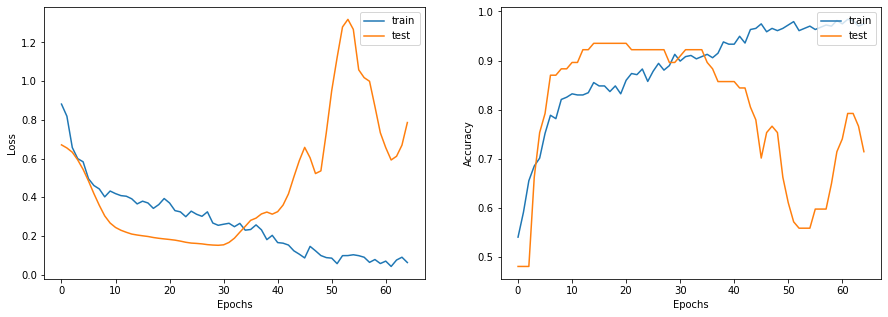

In [97]:
display_learning_curves(history)

In [98]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 92.01%


#### p = 0.2, 0.2 vs 0.8 Test accuracy: 1) 98.2% 2) 98.25% 3) 92.01%

In [99]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [100]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 22.79%
- Reinforcement learning: 77.21%
Instance 2:
- Deep learning: 24.84%
- Reinforcement learning: 75.16%


### p = 0.2, 0.3 vs 0.7

In [101]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1400,1)),np.random.choice(range(1,501),size=(1400,1))]).reshape(1400,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1400,1)),np.random.choice(range(501,1001),size=(1400,1))]).reshape(1400,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [102]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [103]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [104]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [105]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

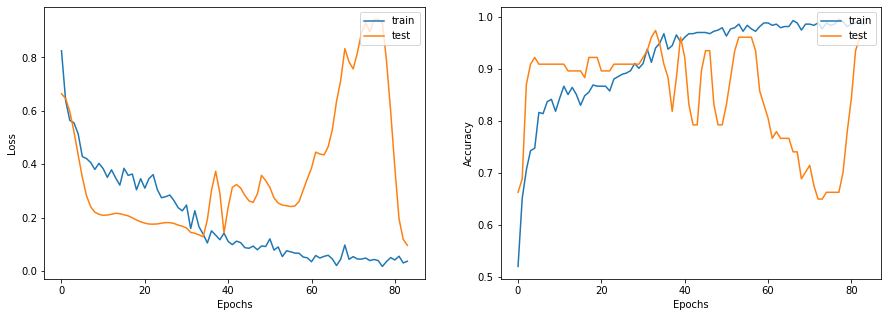

In [106]:
display_learning_curves(history)

In [107]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.34%


#### p = 0.2, 0.3 vs 0.7 Test accuracy: 1) 93.2% 2) 98.64% 3) 97.34%

In [108]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [109]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 53.23%
- Reinforcement learning: 46.77%
Instance 2:
- Deep learning: 11.01%
- Reinforcement learning: 88.99%


### p = 0.2, 0.4 vs 0.6

In [110]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(1,501),size=(1200,1))]).reshape(1200,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [111]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [112]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [113]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [114]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

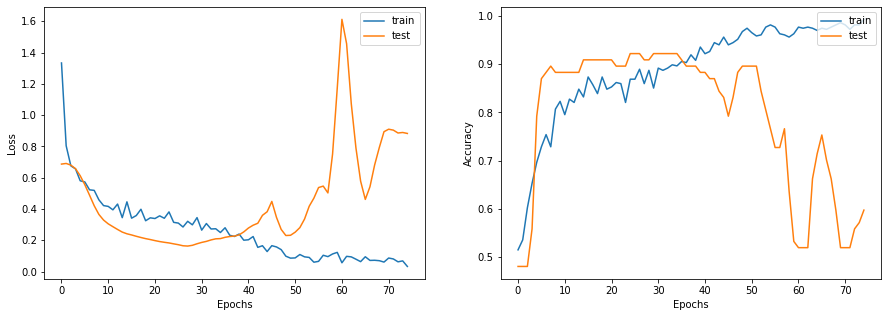

In [115]:
display_learning_curves(history)

In [116]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 96.11%


#### p = 0.2, 0.4 vs 0.6 Test accuracy: 1) 96.6% 2) 96.11% 3) 96.11%

In [117]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [118]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 5.57%
- Reinforcement learning: 94.43%
Instance 2:
- Deep learning: 23.03%
- Reinforcement learning: 76.97%


## p=0.3

### 데이터 구성

In [119]:
p=0.3

In [120]:
papers =pd.concat([pd.concat([pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X4','X5','X6']),
                             pd.DataFrame(np.array([['Deep learning']*500]).reshape(500,1),columns=['subject'])],axis=1),
            pd.concat([ pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X1','X2','X3']),
              pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X4','X5','X6']),
                      pd.DataFrame(np.array([['Reinforcement learning']*500]).reshape(500,1),columns=['subject'])],axis=1)],axis=0,ignore_index=True).reset_index().rename(columns={'index':'paper_id'})
papers['paper_id'] = papers['paper_id']+1

In [121]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1000,1)),np.random.choice(range(1,501),size=(1000,1))]).reshape(1000,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1000,1)),np.random.choice(range(501,1001),size=(1000,1))]).reshape(1000,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2000,1)),np.random.choice(range(501,1001),size=(2000,1))]).reshape(2000,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

### 그래프 표현

In [122]:
#collapse
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

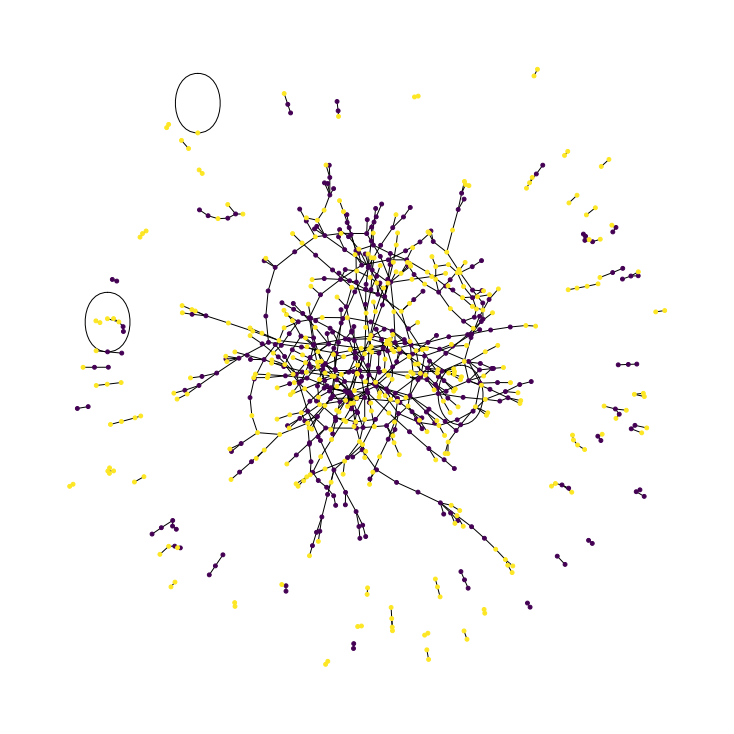

In [123]:
#collapse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [124]:
#collapse
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (538, 8)
Test data shape: (462, 8)


In [125]:
#collapse
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [126]:
#collapse
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [127]:
#collapse_output
history = run_experiment(baseline_model, x_train, y_train)

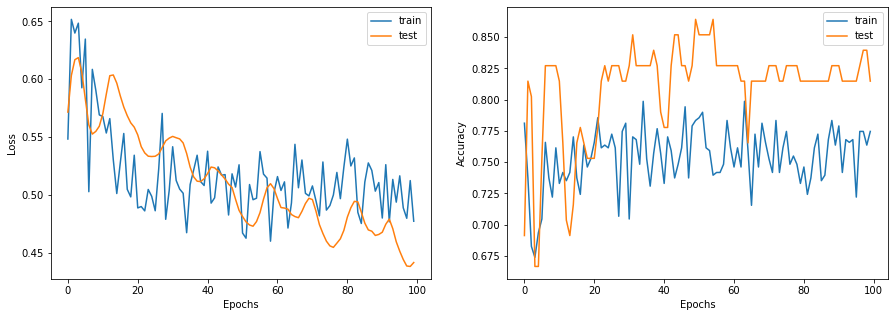

In [128]:
display_learning_curves(history)

In [129]:
#collapse
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 85.28%


#### p=0.3 Test accuracy: 1) 82.41% 2) 83.13% 3) 85.28%

### baseline 모델 예측

In [130]:
#collapse
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 69.93%
- Reinforcement learning: 30.07%
Instance 2:
- Deep learning: 26.65%
- Reinforcement learning: 73.35%


In [131]:
#collapse
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 4000)
Edge weight shape: (4000,)
Nodes shape: (1000, 6)


In [132]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.10487258 -0.01363682]
 [-0.00738653 -0.1214926 ]
 [-0.15111339 -0.07072159]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1000, 32)                1432      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (1000, 32)                2368      
                                                                 
 logits (Dense)              multiple           

### Train the GNN model

In [133]:
#collapse_Output
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

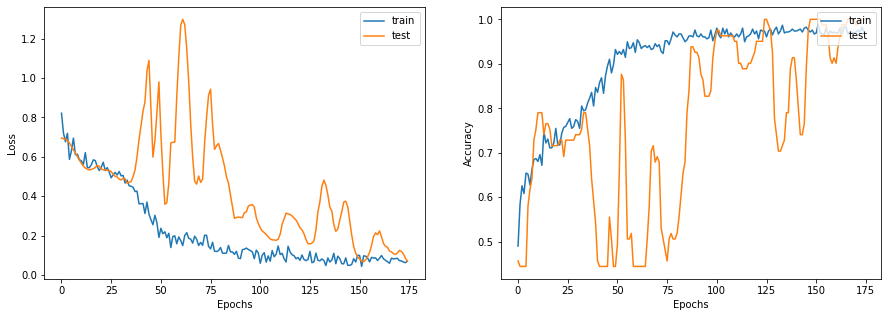

In [134]:
display_learning_curves(history)

In [135]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.19%


#### p=0.3, 0.5 vs 0.5 Test accuracy: 1) 87.12% 2) 83.54% 3) 97.19%

In [136]:
#collapse
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [137]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 99.98%
- Reinforcement learning: 0.02%
Instance 2:
- Deep learning: 0.03%
- Reinforcement learning: 99.97%


### p = 0.3, 0.1 vs 0.9

In [143]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1800,1)),np.random.choice(range(1,501),size=(1800,1))]).reshape(1800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1800,1)),np.random.choice(range(501,1001),size=(1800,1))]).reshape(1800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(400,1)),np.random.choice(range(501,1001),size=(400,1))]).reshape(400,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [144]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [145]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [146]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [147]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

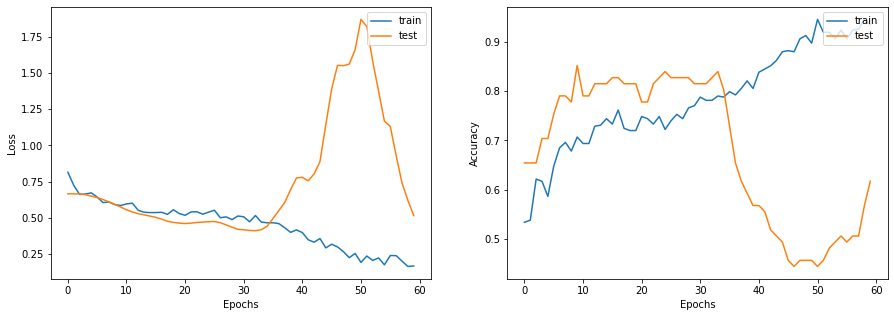

In [148]:
display_learning_curves(history)

In [149]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 86.8%


#### p = 0.3, 0.1 vs 0.9 Test accuracy: 1) 92.02% 2) 95.93% 3) 86.8%

In [150]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [151]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 60.82%
- Reinforcement learning: 39.18%
Instance 2:
- Deep learning: 34.92%
- Reinforcement learning: 65.08%


### p = 0.3, 0.2 vs 0.8

In [152]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(1,501),size=(1600,1))]).reshape(1600,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(800,1)),np.random.choice(range(501,1001),size=(800,1))]).reshape(800,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [153]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [154]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [155]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [156]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

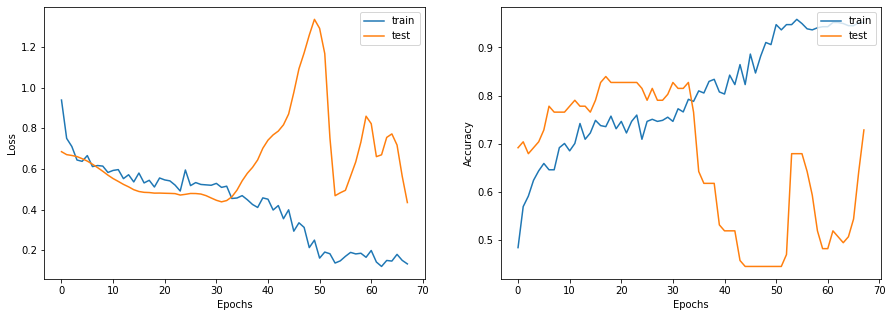

In [157]:
display_learning_curves(history)

In [158]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 87.01%


#### p = 0.3, 0.2 vs 0.8 Test accuracy: 1) 97.34% 2) 96.54% 3) 87.01%

In [159]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [160]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 71.22%
- Reinforcement learning: 28.78%
Instance 2:
- Deep learning: 35.78%
- Reinforcement learning: 64.22%


### p = 0.3, 0.3 vs 0.7

In [161]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1400,1)),np.random.choice(range(1,501),size=(1400,1))]).reshape(1400,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1400,1)),np.random.choice(range(501,1001),size=(1400,1))]).reshape(1400,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [162]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [163]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [164]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [165]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

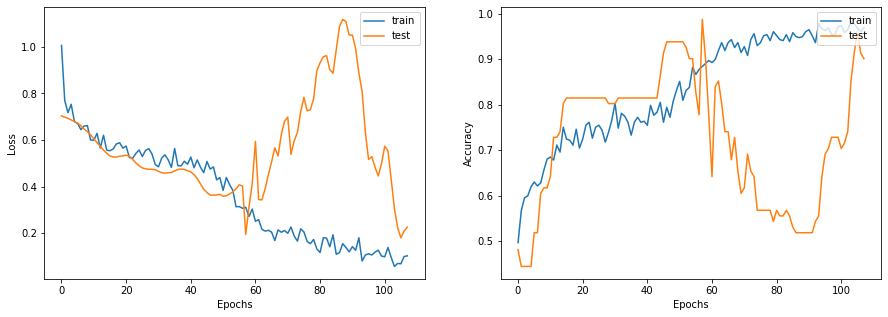

In [166]:
display_learning_curves(history)

In [167]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.84%


#### p = 0.3, 0.3 vs 0.7 Test accuracy: 1) 96.73% 2) 85.57% 3) 97.84%

In [168]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [169]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 96.54%
- Reinforcement learning: 3.46%
Instance 2:
- Deep learning: 9.7%
- Reinforcement learning: 90.3%


### p = 0.3, 0.4 vs 0.6

In [170]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(1,501),size=(1200,1))]).reshape(1200,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [171]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [172]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [173]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [174]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

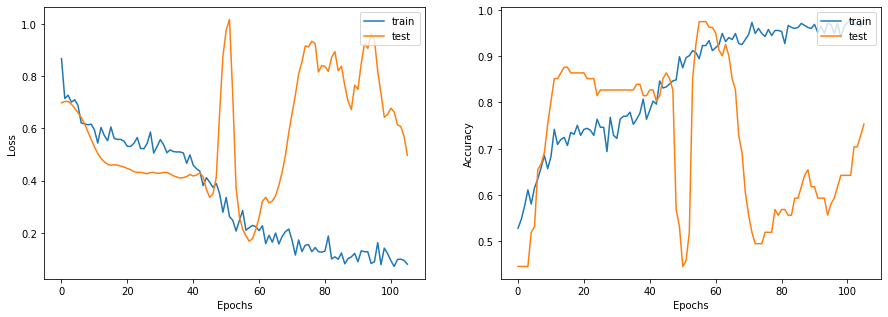

In [175]:
display_learning_curves(history)

In [176]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.62%


#### p = 0.3, 0.5 vs 0.6 Test accuracy: 1) 97.55% 2) 82.93% 3) 97.62%

In [177]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [178]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 96.67%
- Reinforcement learning: 3.33%
Instance 2:
- Deep learning: 2.2%
- Reinforcement learning: 97.8%


## p=0.4

### 데이터 구성

In [198]:
p=0.4

In [199]:
papers =pd.concat([pd.concat([pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X4','X5','X6']),
                             pd.DataFrame(np.array([['Deep learning']*500]).reshape(500,1),columns=['subject'])],axis=1),
            pd.concat([ pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X1','X2','X3']),
              pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X4','X5','X6']),
                      pd.DataFrame(np.array([['Reinforcement learning']*500]).reshape(500,1),columns=['subject'])],axis=1)],axis=0,ignore_index=True).reset_index().rename(columns={'index':'paper_id'})
papers['paper_id'] = papers['paper_id']+1

In [200]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1000,1)),np.random.choice(range(1,501),size=(1000,1))]).reshape(1000,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1000,1)),np.random.choice(range(501,1001),size=(1000,1))]).reshape(1000,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2000,1)),np.random.choice(range(501,1001),size=(2000,1))]).reshape(2000,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

### 그래프 표현

In [201]:
#collapse
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

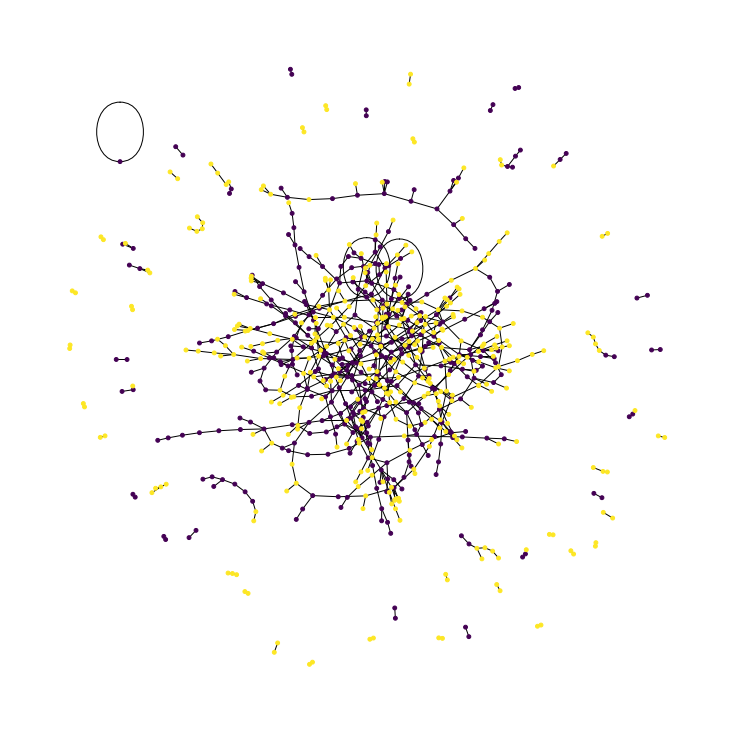

In [202]:
#collapse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [203]:
#collapse
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (489, 8)
Test data shape: (511, 8)


In [204]:
#collapse
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [205]:
#collapse
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [206]:
#collapse_output
history = run_experiment(baseline_model, x_train, y_train)

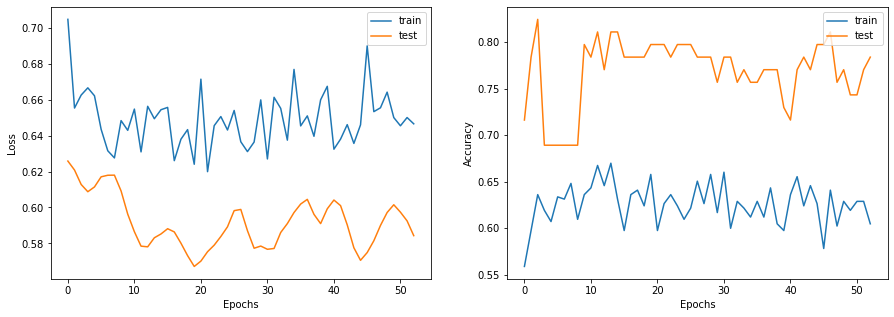

In [207]:
display_learning_curves(history)

In [208]:
#collapse
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.67%


#### p=0.4 Test accuracy: 1) 65.56% 2) 72.73% 3) 69.67%

### baseline 모델 예측

In [212]:
#collapse
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 56.52%
- Reinforcement learning: 43.48%
Instance 2:
- Deep learning: 35.46%
- Reinforcement learning: 64.54%


In [213]:
#collapse
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 4000)
Edge weight shape: (4000,)
Nodes shape: (1000, 6)


In [214]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.23952529 -0.03761969]
 [ 0.18715619 -0.04318785]
 [ 0.20817909  0.02209835]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1000, 32)                1432      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (1000, 32)                2368      
                                                                 
 logits (Dense)              multiple           

### Train the GNN model

In [215]:
#collapse_Output
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

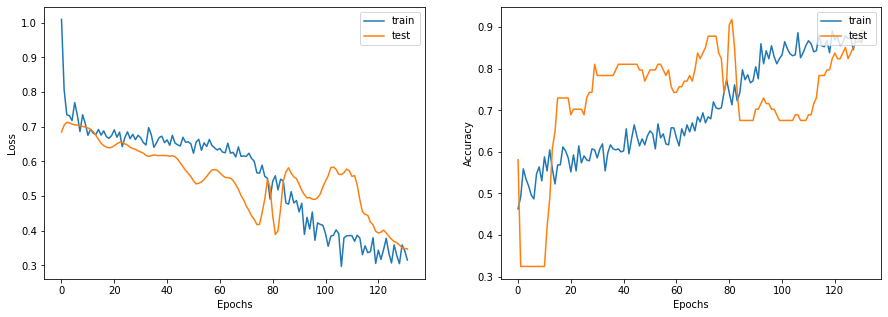

In [216]:
display_learning_curves(history)

In [217]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 82.0%


#### p=0.4, 0.5 vs 0.5 Test accuracy: 1) 85.91% 2) 71.02% 3) 82.0%

In [218]:
#collapse
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [219]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 61.64%
- Reinforcement learning: 38.36%
Instance 2:
- Deep learning: 22.3%
- Reinforcement learning: 77.7%


### p = 0.4, 0.1 vs 0.9

In [220]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1800,1)),np.random.choice(range(1,501),size=(1800,1))]).reshape(1800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1800,1)),np.random.choice(range(501,1001),size=(1800,1))]).reshape(1800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(400,1)),np.random.choice(range(501,1001),size=(400,1))]).reshape(400,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [221]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [222]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [223]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [224]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

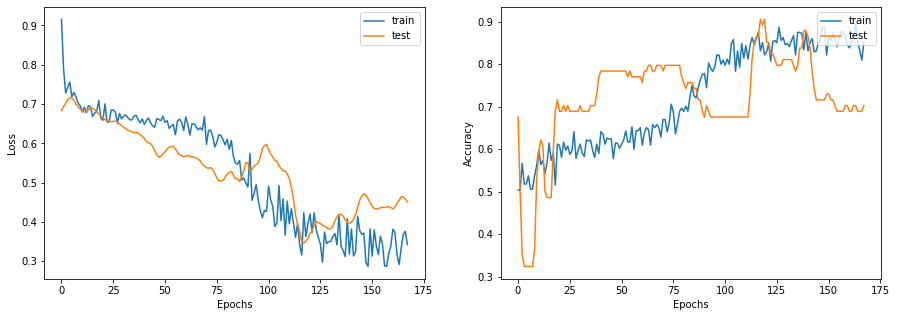

In [225]:
display_learning_curves(history)

In [226]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 87.28%


#### p = 0.4, 0.1 vs 0.9 Test accuracy: 1) 87.08% 2) 92.23% 3) 87.28%

In [227]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [228]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 97.16%
- Reinforcement learning: 2.84%
Instance 2:
- Deep learning: 10.43%
- Reinforcement learning: 89.57%


### p = 0.4, 0.2 vs 0.8

In [229]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(1,501),size=(1600,1))]).reshape(1600,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(800,1)),np.random.choice(range(501,1001),size=(800,1))]).reshape(800,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [230]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [231]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [232]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [233]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

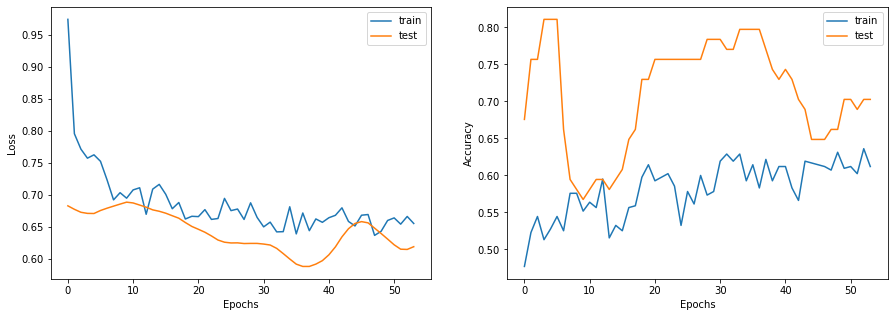

In [234]:
display_learning_curves(history)

In [235]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 61.06%


#### p = 0.4, 0.2 vs 0.8 Test accuracy: 1) 76.13% 2) 92.99% 3) 61.06%

In [236]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [237]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 54.7%
- Reinforcement learning: 45.3%
Instance 2:
- Deep learning: 50.93%
- Reinforcement learning: 49.07%


### p = 0.4, 0.3 vs 0.7

In [238]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1400,1)),np.random.choice(range(1,501),size=(1400,1))]).reshape(1400,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1400,1)),np.random.choice(range(501,1001),size=(1400,1))]).reshape(1400,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [239]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [240]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [241]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [242]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

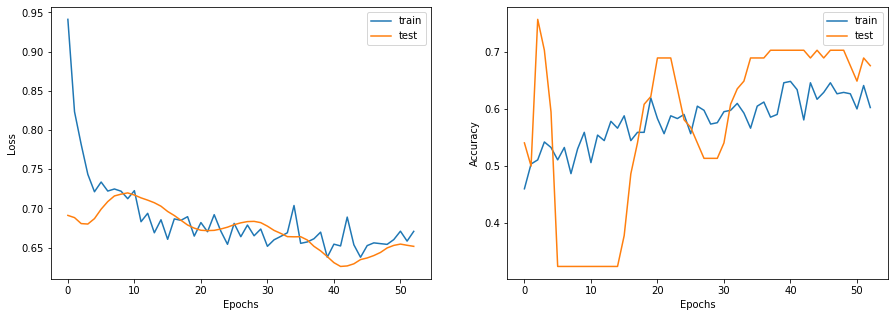

In [243]:
display_learning_curves(history)

In [244]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 66.93%


#### p = 0.4, 0.3 vs 0.7 Test accuracy: 1) 87.87% 2) 68.37% 3) 66.93%

In [245]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [246]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 49.93%
- Reinforcement learning: 50.07%
Instance 2:
- Deep learning: 48.97%
- Reinforcement learning: 51.03%


### p = 0.4, 0.4 vs 0.6

In [247]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(1,501),size=(1200,1))]).reshape(1200,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [248]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [249]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [250]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [251]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

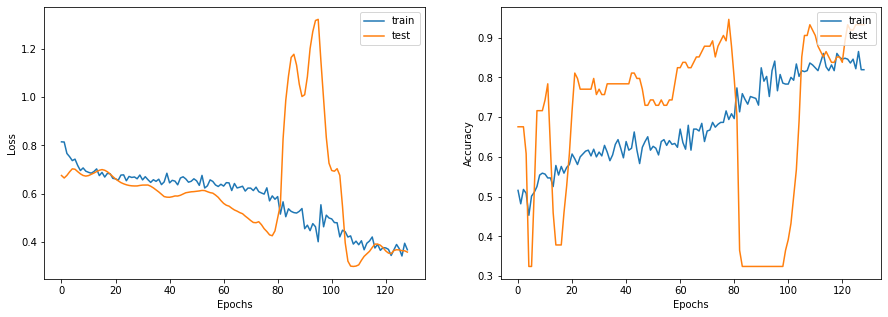

In [252]:
display_learning_curves(history)

In [253]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 85.71%


#### p = 0.4, 0.4 vs 0.6 Test accuracy: 1) 86.5% 2) 88.45% 3) 85.71%

In [254]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [255]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 66.34%
- Reinforcement learning: 33.66%
Instance 2:
- Deep learning: 26.35%
- Reinforcement learning: 73.65%


## p=0.5

### 데이터 구성

In [256]:
p=0.5

In [257]:
papers =pd.concat([pd.concat([pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X1','X2','X3']),
           pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X4','X5','X6']),
                             pd.DataFrame(np.array([['Deep learning']*500]).reshape(500,1),columns=['subject'])],axis=1),
            pd.concat([ pd.DataFrame(np.random.choice(2, 1500, p=[1-p,p]).reshape(500,3),columns=['X1','X2','X3']),
              pd.DataFrame(np.random.choice(2, 1500, p=[p,1-p]).reshape(500,3),columns=['X4','X5','X6']),
                      pd.DataFrame(np.array([['Reinforcement learning']*500]).reshape(500,1),columns=['subject'])],axis=1)],axis=0,ignore_index=True).reset_index().rename(columns={'index':'paper_id'})
papers['paper_id'] = papers['paper_id']+1

In [258]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1000,1)),np.random.choice(range(1,501),size=(1000,1))]).reshape(1000,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1000,1)),np.random.choice(range(501,1001),size=(1000,1))]).reshape(1000,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(2000,1)),np.random.choice(range(501,1001),size=(2000,1))]).reshape(2000,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

### 그래프 표현

In [259]:
#collapse
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

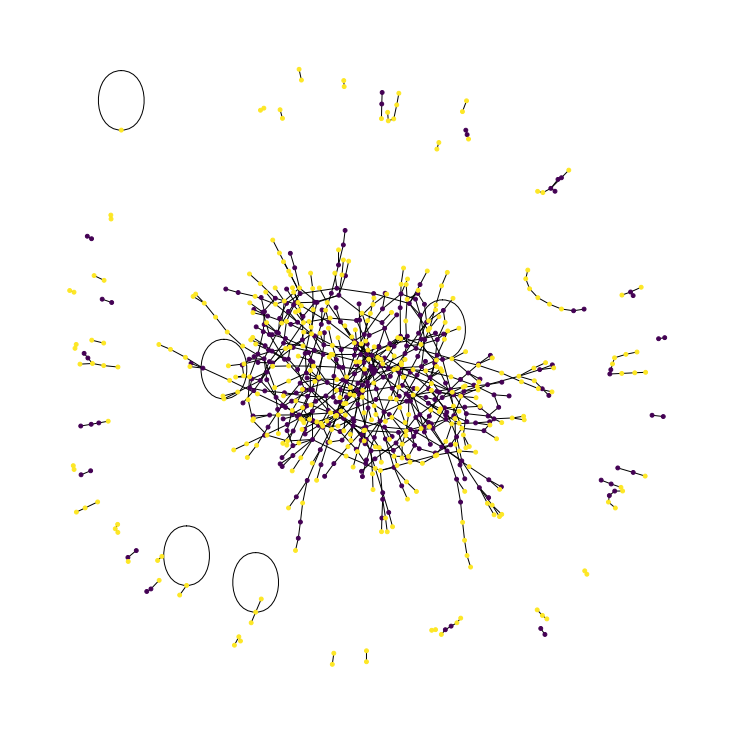

In [260]:
#collapse
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=800))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Test vs Train

In [261]:
#collapse
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (494, 8)
Test data shape: (506, 8)


In [262]:
#collapse
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [263]:
#collapse
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [264]:
#collapse_output
history = run_experiment(baseline_model, x_train, y_train)

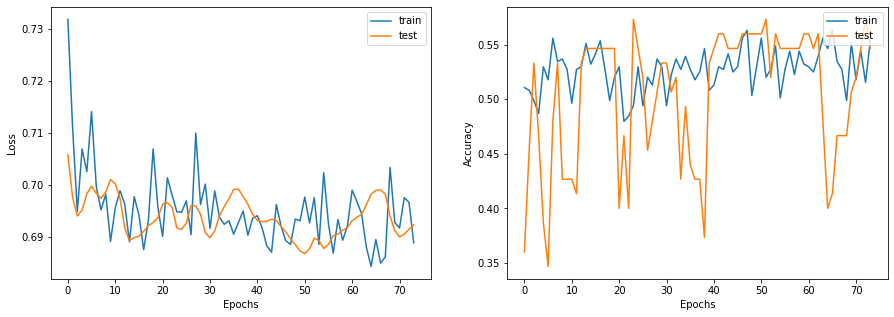

In [265]:
display_learning_curves(history)

In [266]:
#collapse
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 47.43%


#### p=0.5 Test accuracy: 1) 52.76% 2) 49.9% 3) 47.43%

### baseline 모델 예측

In [267]:
#collapse
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Deep learning: 49.33%
- Reinforcement learning: 50.67%
Instance 2:
- Deep learning: 48.57%
- Reinforcement learning: 51.43%


In [268]:
#collapse
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Edge weight shape:", edge_weights.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 4000)
Edge weight shape: (4000,)
Nodes shape: (1000, 6)


In [269]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.10873301  0.01855849]
 [ 0.08539138 -0.03099397]
 [-0.03729483 -0.08653323]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (1000, 32)                1432      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (1000, 32)                2368      
                                                                 
 logits (Dense)              multiple           

### Train the GNN model

In [270]:
#collapse_Output
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

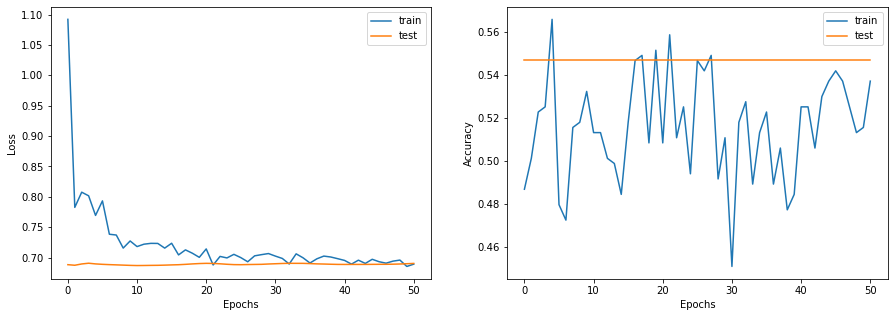

In [271]:
display_learning_curves(history)

In [272]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 46.84%


#### p=0.5, 0.5 vs 0.5 Test accuracy: 1) 51.38% 2) 48.53%

In [273]:
#collapse
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [274]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 45.39%
- Reinforcement learning: 54.61%
Instance 2:
- Deep learning: 44.81%
- Reinforcement learning: 55.19%


### p = 0.5, 0.1 vs 0.9

In [275]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1800,1)),np.random.choice(range(1,501),size=(1800,1))]).reshape(1800,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1800,1)),np.random.choice(range(501,1001),size=(1800,1))]).reshape(1800,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(400,1)),np.random.choice(range(501,1001),size=(400,1))]).reshape(400,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [276]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [277]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [278]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [279]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

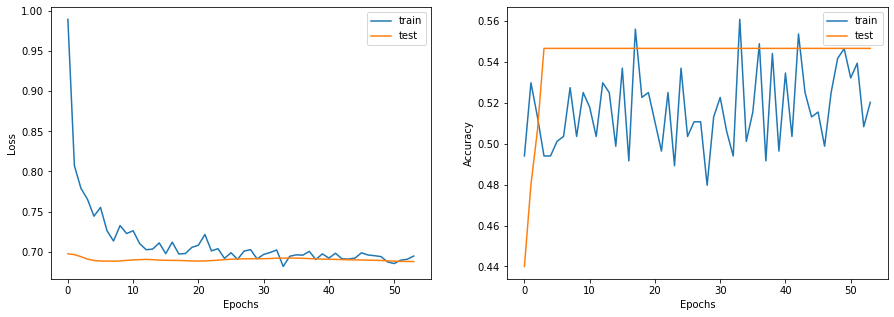

In [280]:
display_learning_curves(history)

In [281]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 46.84%


#### p = 0.5, 0.1 vs 0.9 Test accuracy: 1) 43.5% 2) 46.97% 3) 46.84%

In [282]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [283]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 48.53%
- Reinforcement learning: 51.47%
Instance 2:
- Deep learning: 49.98%
- Reinforcement learning: 50.02%


### p = 0.5, 0.2 vs 0.8

In [284]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(1,501),size=(1600,1))]).reshape(1600,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(800,1)),np.random.choice(range(501,1001),size=(800,1))]).reshape(800,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [285]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [286]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [287]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [288]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

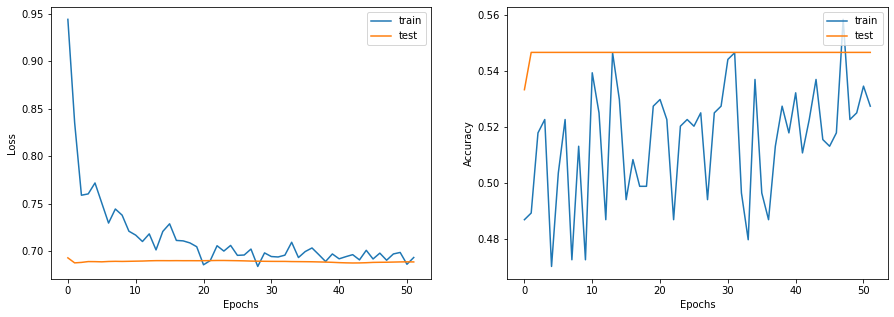

In [289]:
display_learning_curves(history)

In [290]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 46.84%


#### p = 0.5, 0.2 vs 0.8 Test accuracy: 1) 49.8% 2) 49.9% 3) 46.84%

In [291]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [292]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 44.14%
- Reinforcement learning: 55.86%
Instance 2:
- Deep learning: 43.02%
- Reinforcement learning: 56.98%


### p = 0.5, 0.3 vs 0.7

In [293]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1400,1)),np.random.choice(range(1,501),size=(1400,1))]).reshape(1400,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1400,1)),np.random.choice(range(501,1001),size=(1400,1))]).reshape(1400,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [294]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [295]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [296]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [297]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

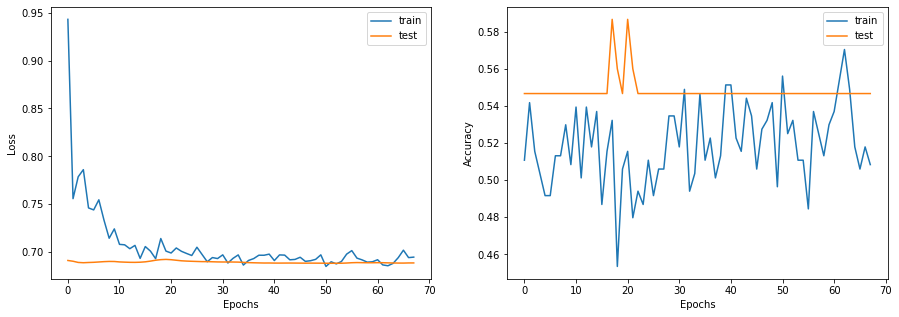

In [298]:
display_learning_curves(history)

In [299]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 46.05%


#### p = 0.5, 0.3 vs 0.7 Test accuracy: 1) 52.36% 2) 45.21% 3) 46.05%

In [300]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [301]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 48.66%
- Reinforcement learning: 51.34%
Instance 2:
- Deep learning: 47.88%
- Reinforcement learning: 52.12%


### p = 0.5, 0.4 vs 0.6

In [302]:
citations =  pd.concat([pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1200,1)),np.random.choice(range(1,501),size=(1200,1))]).reshape(1200,2)),
                          pd.DataFrame(np.array([np.random.choice(range(501,1001),size=(1200,1)),np.random.choice(range(501,1001),size=(1200,1))]).reshape(1200,2)),
                       pd.DataFrame(np.array([np.random.choice(range(1,501),size=(1600,1)),np.random.choice(range(501,1001),size=(1600,1))]).reshape(1600,2))],ignore_index=True).rename(columns={0:'target',1:'source'})

In [303]:
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

In [304]:
#collapse
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

### Train the GNN model

In [305]:
#collapse
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [306]:
#collapse_Output
history = run_experiment(gnn_model, x_train, y_train)

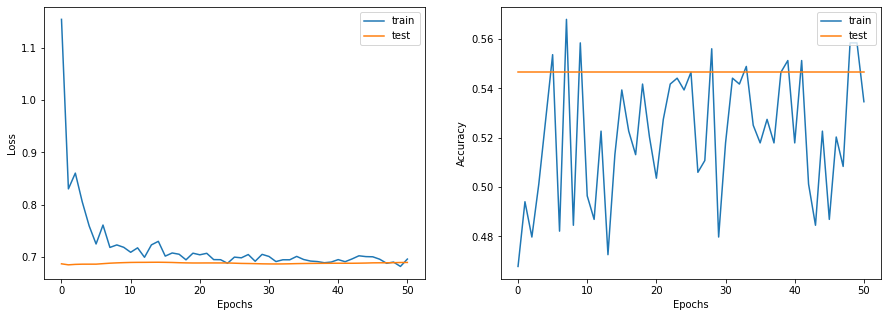

In [307]:
display_learning_curves(history)

In [308]:
#collapse
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 46.84%


#### p = 0.5, 0.5 vs 0.6 Test accuracy: 1) 45.87% 2) 47.36% 3) 46.84%

In [309]:
#collapse
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [310]:
#collapse
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (1000, 6)
Original edges shape: (2, 4000)
New node_features shape: (1002, 6)
New edges shape: (2, 4014)
Instance 1:
- Deep learning: 46.83%
- Reinforcement learning: 53.17%
Instance 2:
- Deep learning: 47.03%
- Reinforcement learning: 52.97%
